In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import cv2, random
from pathlib import Path
import dataclasses

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


from warnings import filterwarnings
filterwarnings("ignore")

import os
import sys
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", "..", ".."))
from src.detector.get_dicts import get_COVID19_data_dicts
from src.detector.custom_trainer import MyTrainer
from src.detector.flags import Flags
from src.detector.save_yaml import save_yaml


setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
flags_dict = {
    "debug": False,
    "fold": 2,
    "outdir": "results/", 
    "root_imgdir": PATH_TO_IMAGES, # !!! DEFINE "PATH_TO_IMAGES" on your local machine,
    "path_to_meta_df": "../../cross_validation_scheme/modified_detectron_data/meta_df.csv",
    "path_to_train_df": "../../cross_validation_scheme/modified_detectron_data/detectron_prepared_df.csv",
    "use_cache": False,
    "img_size": "1024x1024",
    "cv_scheme": "skf",
    "use_negative": False,
    "binary_task": True,
    
    "iter": 4000,
    "roi_batch_size_per_image": 256,
    "eval_period": 1000,
#     "lr_scheduler_name": "WarmupMultiStepLR",
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.0025,
    "num_workers": 4,
    "ims_per_batch": 8,
    
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "HueSaturationValue": {"hue_shift_limit": 10, "sat_shift_limit": 10, "val_shift_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CLAHE": {"clip_limit": (1,4), "p": 0.5},
        "GaussianBlur": {"p": 0.5}
    },
}

In [3]:
flags = Flags().update(flags_dict)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

In [4]:
thing_classes = [
    "opacity"
]

In [5]:
DatasetCatalog.register(
    "COVID19_data_train",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='train',
                                    fold=flags.fold,
                                  ),
)
MetadataCatalog.get("COVID19_data_train").set(thing_classes=thing_classes)


DatasetCatalog.register(
    "COVID19_data_valid",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='val',
                                    fold=flags.fold,
                                  ),
    )
MetadataCatalog.get("COVID19_data_valid").set(thing_classes=thing_classes)

dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")

dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")

  1%|▏         | 70/4836 [00:00<00:06, 699.78it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


  7%|▋         | 79/1194 [00:00<00:01, 785.63it/s]

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 792.02it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl


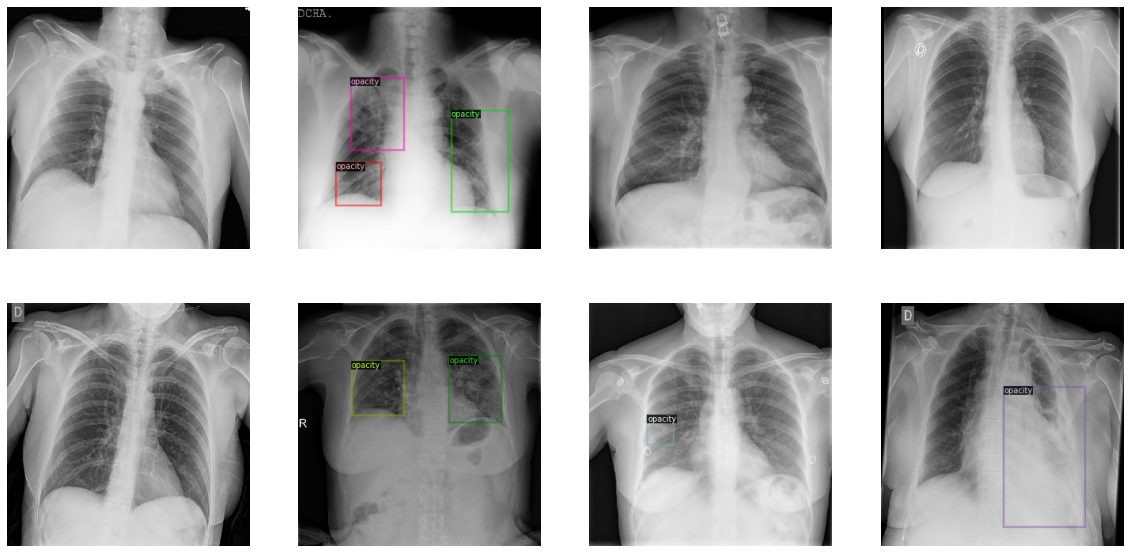

In [6]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [7]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = flags.outdir
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("COVID19_data_train",)
cfg.DATASETS.TEST = ("COVID19_data_valid",)
cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Loading config /home/greylord/siim_covid/covid_env/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> results/


In [8]:
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/30 21:43:48 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

  2%|▏         | 79/4836 [00:00<00:06, 780.73it/s]

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-10, 10), sat_shift_limit=(-10, 10), val_shift_limit=(-10, 10)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
  GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=(0, 0)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating dat

100%|██████████| 4836/4836 [00:06<00:00, 764.31it/s]

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 21:43:54 d2.data.build]: Removed 1388 images with no usable annotations. 3448 images left.


[07/30 21:43:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 6322         |
|            |              |
[07/30 21:43:54 d2.data.build]: Using training sampler TrainingSampler
[07/30 21:43:54 d2.data.common]: Serializing 3448 elements to byte tensors and concatenating them all ...
[07/30 21:43:54 d2.data.common]: Serialized dataset takes 1.21 MiB


  0%|          | 0/1194 [00:00<?, ?it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 762.18it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 21:43:56 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 1530         |
|            |              |
[07/30 21:43:56 d2.data.common]: Serializing 1194 elements to byte tensors and concatenating them all ...
[07/30 21:43:56 d2.data.common]: Serialized dataset takes 0.36 MiB


[07/30 21:43:56 d2.engine.train_loop]: Starting training from iteration 0
[07/30 21:44:22 d2.utils.events]:  eta: 1:26:13  iter: 19  total_loss: 1.985  loss_cls: 1.198  loss_box_reg: 0.8123  time: 1.2846  data_time: 0.0291  lr: 4.2996e-05  max_mem: 18669M
[07/30 21:44:49 d2.utils.events]:  eta: 1:26:59  iter: 39  total_loss: 1.141  loss_cls: 0.5418  loss_box_reg: 0.6048  time: 1.3032  data_time: 0.0172  lr: 8.5624e-05  max_mem: 18669M
[07/30 21:45:15 d2.utils.events]:  eta: 1:25:57  iter: 59  total_loss: 0.9742  loss_cls: 0.4604  loss_box_reg: 0.5084  time: 1.3025  data_time: 0.0171  lr: 0.00012825  max_mem: 18669M
[07/30 21:45:41 d2.utils.events]:  eta: 1:25:30  iter: 79  total_loss: 0.9393  loss_cls: 0.4178  loss_box_reg: 0.5205  time: 1.3037  data_time: 0.0168  lr: 0.00017088  max_mem: 18669M
[07/30 21:46:07 d2.utils.events]:  eta: 1:25:09  iter: 99  total_loss: 0.8868  loss_cls: 0.4031  loss_box_reg: 0.4838  time: 1.3065  data_time: 0.0166  lr: 0.00021351  max_mem: 18669M
[07/30 21

[07/30 22:02:53 d2.utils.events]:  eta: 1:07:51  iter: 879  total_loss: 0.7549  loss_cls: 0.3189  loss_box_reg: 0.4365  time: 1.2907  data_time: 0.0175  lr: 0.001876  max_mem: 18669M
[07/30 22:03:15 d2.utils.events]:  eta: 1:07:24  iter: 899  total_loss: 0.7564  loss_cls: 0.3172  loss_box_reg: 0.4356  time: 1.2864  data_time: 0.0175  lr: 0.0019186  max_mem: 18669M
[07/30 22:03:37 d2.utils.events]:  eta: 1:06:56  iter: 919  total_loss: 0.7934  loss_cls: 0.3638  loss_box_reg: 0.4614  time: 1.2827  data_time: 0.0186  lr: 0.0019612  max_mem: 18669M
[07/30 22:04:02 d2.utils.events]:  eta: 1:06:29  iter: 939  total_loss: 0.758  loss_cls: 0.3255  loss_box_reg: 0.4255  time: 1.2824  data_time: 0.0184  lr: 0.0020039  max_mem: 18669M
[07/30 22:04:29 d2.utils.events]:  eta: 1:06:04  iter: 959  total_loss: 0.7371  loss_cls: 0.32  loss_box_reg: 0.4278  time: 1.2830  data_time: 0.0188  lr: 0.0020465  max_mem: 18669M
[07/30 22:04:55 d2.utils.events]:  eta: 1:05:39  iter: 979  total_loss: 0.7457  loss

  7%|▋         | 79/1194 [00:00<00:01, 786.24it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 783.56it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 22:05:22 d2.data.common]: Serializing 1194 elements to byte tensors and concatenating them all ...
[07/30 22:05:22 d2.data.common]: Serialized dataset takes 0.36 MiB
[07/30 22:05:22 d2.evaluation.coco_evaluation]: 'COVID19_data_valid' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/30 22:05:22 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_valid' to COCO format ...)



  7%|▋         | 80/1194 [00:00<00:01, 794.20it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 791.02it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 22:05:23 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[07/30 22:05:23 d2.data.datasets.coco]: Conversion finished, #images: 1194, #annotations: 1530
[07/30 22:05:23 d2.data.datasets.coco]: Caching COCO format annotations at 'results/inference/COVID19_data_valid_coco_format.json' ...
[07/30 22:05:23 d2.evaluation.evaluator]: Start inference on 1194 images
[07/30 22:05:24 d2.evaluation.evaluator]: Inference done 11/1194. 0.0550 s / img. ETA=0:01:06
[07/30 22:05:29 d2.evaluation.evaluator]: Inference done 97/1194. 0.0561 s / img. ETA=0:01:03
[07/30 22:05:34 d2.evaluation.evaluator]: Inference done 181/1194. 0.0567 s / img. ETA=0:00:59
[07/30 22:05:39 d2.evaluation.evaluator]: Inference done 254/1194. 0.0596 s / img. ETA=0:00:58
[07/30 22:05:44 d2.evaluation.evaluator]: Inference done 340/1194. 0.0587 s / img. ETA=0:00:52
[07/30 22:05:49 d2.evaluation.evaluator]: Inference done 413/1194. 0.0602 s / img. ETA=0:00:48
[07/30 22:05:54 d2.evaluation.evaluator]: Inference done 486/1194. 0.0612 s / img. ETA=0:00:44
[07/30 22:05:59 d2.evaluation.eval

[07/30 22:14:19 d2.utils.events]:  eta: 0:57:34  iter: 1319  total_loss: 0.7716  loss_cls: 0.3219  loss_box_reg: 0.4457  validation_loss: 0.8042  time: 1.2449  data_time: 0.0180  lr: 0.0018871  max_mem: 18669M
[07/30 22:14:41 d2.utils.events]:  eta: 0:56:59  iter: 1339  total_loss: 0.7344  loss_cls: 0.3076  loss_box_reg: 0.4333  validation_loss: 0.8042  time: 1.2430  data_time: 0.0179  lr: 0.0018702  max_mem: 18669M
[07/30 22:15:02 d2.utils.events]:  eta: 0:56:13  iter: 1359  total_loss: 0.7116  loss_cls: 0.2889  loss_box_reg: 0.4231  validation_loss: 0.8042  time: 1.2405  data_time: 0.0175  lr: 0.0018531  max_mem: 18669M
[07/30 22:15:24 d2.utils.events]:  eta: 0:55:04  iter: 1379  total_loss: 0.7712  loss_cls: 0.3273  loss_box_reg: 0.4402  validation_loss: 0.8042  time: 1.2380  data_time: 0.0177  lr: 0.0018358  max_mem: 18669M
[07/30 22:15:46 d2.utils.events]:  eta: 0:53:00  iter: 1399  total_loss: 0.736  loss_cls: 0.3003  loss_box_reg: 0.4316  validation_loss: 0.8042  time: 1.2361  d

  6%|▌         | 72/1194 [00:00<00:01, 714.21it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 749.30it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 22:27:34 d2.data.common]: Serializing 1194 elements to byte tensors and concatenating them all ...
[07/30 22:27:34 d2.data.common]: Serialized dataset takes 0.36 MiB
[07/30 22:27:34 d2.evaluation.evaluator]: Start inference on 1194 images
[07/30 22:27:35 d2.evaluation.evaluator]: Inference done 11/1194. 0.0657 s / img. ETA=0:01:19
[07/30 22:27:40 d2.evaluation.evaluator]: Inference done 85/1194. 0.0660 s / img. ETA=0:01:15
[07/30 22:27:45 d2.evaluation.evaluator]: Inference done 159/1194. 0.0661 s / img. ETA=0:01:10
[07/30 22:27:50 d2.evaluation.evaluator]: Inference done 233/1194. 0.0661 s / img. ETA=0:01:05
[07/30 22:27:55 d2.evaluation.evaluator]: Inference done 307/1194. 0.0661 s / img. ETA=0:01:00
[07/30 22:28:00 d2.evaluation.evaluator]: Inference done 380/1194. 0.0663 s / img. ETA=0:00:55
[07/30 22:28:05 d2.evaluation.evaluator]: Inference done 453/1194.

[07/30 22:36:40 d2.utils.events]:  eta: 0:31:08  iter: 2319  total_loss: 0.7267  loss_cls: 0.3105  loss_box_reg: 0.4158  validation_loss: 0.7767  time: 1.2117  data_time: 0.0185  lr: 0.00094009  max_mem: 18669M
[07/30 22:37:03 d2.utils.events]:  eta: 0:30:47  iter: 2339  total_loss: 0.6993  loss_cls: 0.3052  loss_box_reg: 0.4063  validation_loss: 0.7767  time: 1.2108  data_time: 0.0181  lr: 0.00092111  max_mem: 18669M
[07/30 22:37:28 d2.utils.events]:  eta: 0:30:43  iter: 2359  total_loss: 0.7252  loss_cls: 0.2934  loss_box_reg: 0.4318  validation_loss: 0.7767  time: 1.2115  data_time: 0.0176  lr: 0.0009022  max_mem: 18669M
[07/30 22:37:55 d2.utils.events]:  eta: 0:30:51  iter: 2379  total_loss: 0.7281  loss_cls: 0.2947  loss_box_reg: 0.4183  validation_loss: 0.7767  time: 1.2124  data_time: 0.0179  lr: 0.00088339  max_mem: 18669M
[07/30 22:38:19 d2.utils.events]:  eta: 0:30:43  iter: 2399  total_loss: 0.6957  loss_cls: 0.2773  loss_box_reg: 0.4184  validation_loss: 0.7767  time: 1.212

  7%|▋         | 80/1194 [00:00<00:01, 797.42it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 803.15it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 22:49:43 d2.data.common]: Serializing 1194 elements to byte tensors and concatenating them all ...
[07/30 22:49:43 d2.data.common]: Serialized dataset takes 0.36 MiB
[07/30 22:49:43 d2.evaluation.evaluator]: Start inference on 1194 images
[07/30 22:49:44 d2.evaluation.evaluator]: Inference done 11/1194. 0.0532 s / img. ETA=0:01:04
[07/30 22:49:49 d2.evaluation.evaluator]: Inference done 102/1194. 0.0534 s / img. ETA=0:01:00
[07/30 22:49:54 d2.evaluation.evaluator]: Inference done 191/1194. 0.0538 s / img. ETA=0:00:55
[07/30 22:49:59 d2.evaluation.evaluator]: Inference done 282/1194. 0.0537 s / img. ETA=0:00:50
[07/30 22:50:04 d2.evaluation.evaluator]: Inference done 373/1194. 0.0536 s / img. ETA=0:00:45
[07/30 22:50:09 d2.evaluation.evaluator]: Inference done 464/1194. 0.0536 s / img. ETA=0:00:40
[07/30 22:50:14 d2.evaluation.evaluator]: Inference done 555/1194

[07/30 22:58:04 d2.utils.events]:  eta: 0:11:38  iter: 3339  total_loss: 0.6325  loss_cls: 0.2521  loss_box_reg: 0.3755  validation_loss: 0.7492  time: 1.1826  data_time: 0.0171  lr: 0.0001647  max_mem: 18669M
[07/30 22:58:25 d2.utils.events]:  eta: 0:11:16  iter: 3359  total_loss: 0.6728  loss_cls: 0.284  loss_box_reg: 0.4029  validation_loss: 0.7492  time: 1.1818  data_time: 0.0174  lr: 0.00015509  max_mem: 18669M
[07/30 22:58:46 d2.utils.events]:  eta: 0:10:55  iter: 3379  total_loss: 0.6692  loss_cls: 0.2678  loss_box_reg: 0.3802  validation_loss: 0.7492  time: 1.1811  data_time: 0.0173  lr: 0.00014575  max_mem: 18669M
[07/30 22:59:07 d2.utils.events]:  eta: 0:10:33  iter: 3399  total_loss: 0.7086  loss_cls: 0.2766  loss_box_reg: 0.4151  validation_loss: 0.7492  time: 1.1803  data_time: 0.0170  lr: 0.00013669  max_mem: 18669M
[07/30 22:59:28 d2.utils.events]:  eta: 0:10:12  iter: 3419  total_loss: 0.6624  loss_cls: 0.2635  loss_box_reg: 0.3837  validation_loss: 0.7492  time: 1.1797

  7%|▋         | 79/1194 [00:00<00:01, 789.17it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 800.92it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 23:09:39 d2.data.common]: Serializing 1194 elements to byte tensors and concatenating them all ...
[07/30 23:09:39 d2.data.common]: Serialized dataset takes 0.36 MiB
[07/30 23:09:39 d2.evaluation.evaluator]: Start inference on 1194 images
[07/30 23:09:40 d2.evaluation.evaluator]: Inference done 11/1194. 0.0530 s / img. ETA=0:01:04
[07/30 23:09:45 d2.evaluation.evaluator]: Inference done 102/1194. 0.0530 s / img. ETA=0:00:59
[07/30 23:09:50 d2.evaluation.evaluator]: Inference done 193/1194. 0.0531 s / img. ETA=0:00:55
[07/30 23:09:55 d2.evaluation.evaluator]: Inference done 284/1194. 0.0531 s / img. ETA=0:00:50
[07/30 23:10:00 d2.evaluation.evaluator]: Inference done 375/1194. 0.0531 s / img. ETA=0:00:45
[07/30 23:10:05 d2.evaluation.evaluator]: Inference done 464/1194. 0.0531 s / img. ETA=0:00:40
[07/30 23:10:10 d2.evaluation.evaluator]: Inference done 555/1194

  7%|▋         | 83/1194 [00:00<00:01, 827.61it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/0049814626c8.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1194/1194 [00:01<00:00, 818.38it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 23:12:02 d2.data.common]: Serializing 1194 elements to byte tensors and concatenating them all ...
[07/30 23:12:02 d2.data.common]: Serialized dataset takes 0.36 MiB
[07/30 23:12:02 d2.evaluation.evaluator]: Start inference on 1194 images


[07/30 23:12:03 d2.evaluation.evaluator]: Inference done 11/1194. 0.0532 s / img. ETA=0:01:04
[07/30 23:12:08 d2.evaluation.evaluator]: Inference done 102/1194. 0.0531 s / img. ETA=0:01:00
[07/30 23:12:13 d2.evaluation.evaluator]: Inference done 193/1194. 0.0531 s / img. ETA=0:00:55
[07/30 23:12:18 d2.evaluation.evaluator]: Inference done 284/1194. 0.0531 s / img. ETA=0:00:50
[07/30 23:12:23 d2.evaluation.evaluator]: Inference done 375/1194. 0.0530 s / img. ETA=0:00:45
[07/30 23:12:28 d2.evaluation.evaluator]: Inference done 466/1194. 0.0531 s / img. ETA=0:00:40
[07/30 23:12:33 d2.evaluation.evaluator]: Inference done 557/1194. 0.0531 s / img. ETA=0:00:35
[07/30 23:12:38 d2.evaluation.evaluator]: Inference done 644/1194. 0.0533 s / img. ETA=0:00:30
[07/30 23:12:43 d2.evaluation.evaluator]: Inference done 730/1194. 0.0537 s / img. ETA=0:00:25
[07/30 23:12:48 d2.evaluation.evaluator]: Inference done 810/1194. 0.0544 s / img. ETA=0:00:21
[07/30 23:12:53 d2.evaluation.evaluator]: Inference

In [9]:
evaluator = COCOEvaluator("COVID19_data_train", cfg, False, output_dir="./results")
val_loader = build_detection_test_loader(cfg, "COVID19_data_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/30 23:13:12 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/30 23:13:12 d2.evaluation.coco_evaluation]: 'COVID19_data_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/30 23:13:12 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_train' to COCO format ...)


  0%|          | 0/4836 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4836/4836 [00:06<00:00, 785.14it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 23:13:18 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/30 23:13:19 d2.data.datasets.coco]: Conversion finished, #images: 4836, #annotations: 6322
[07/30 23:13:19 d2.data.datasets.coco]: Caching COCO format annotations at './results/COVID19_data_train_coco_format.json' ...


  0%|          | 0/4836 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4836/4836 [00:06<00:00, 788.57it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_2_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 23:13:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/30 23:13:25 d2.data.common]: Serializing 4836 elements to byte tensors and concatenating them all ...
[07/30 23:13:25 d2.data.common]: Serialized dataset takes 1.47 MiB
[07/30 23:13:25 d2.evaluation.evaluator]: Start inference on 4836 images
[07/30 23:13:26 d2.evaluation.evaluator]: Inference done 11/4836. 0.0504 s / img. ETA=0:04:06
[07/30 23:13:31 d2.evaluation.evaluator]: Inference done 142/4836. 0.0380 s / img. ETA=0:03:02
[07/30 23:13:36 d2.evaluation.evaluator]: Inference done 270/4836. 0.0382 s / img. ETA=0:02:58
[07/30 23:13:41 d2.evaluation.evaluator]: Inference done 400/4836. 0.0380 s / img. ETA=0:02:52
[07/30 23:13:46 d2.evaluation.evaluator]: Inference done 529/4836. 0.0380 

OrderedDict([('bbox',
              {'AP': 19.51861992465678,
               'AP50': 56.84186609574896,
               'AP75': 7.470799258114013,
               'APs': nan,
               'APm': 3.9137186730613664,
               'APl': 19.746841847592453})])

In [10]:
metrics_df = pd.read_json("results/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,time,total_loss,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.015064,5173.412566,19,0.812343,1.197537,4.299629e-05,54.8125,1.299852,1.984978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.016312,5219.057145,39,0.604848,0.541806,8.562396e-05,55.1250,1.320287,1.141093,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.017086,5157.838677,59,0.508384,0.460435,1.282516e-04,49.7500,1.307988,0.974207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.015784,5130.142794,79,0.520470,0.417798,1.708793e-04,55.0625,1.305825,0.939277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.016012,5109.525944,99,0.483764,0.403079,2.135070e-04,50.3750,1.318867,0.886798,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017097,63.027011,3939,0.422734,0.285071,1.434288e-06,53.6250,1.050027,0.693601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,0.016972,42.013867,3959,0.376522,0.236380,6.480223e-07,52.5000,1.049546,0.613007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0.016693,21.005985,3979,0.386224,0.270580,1.700155e-07,48.1875,1.046866,0.676852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,0.016523,0.000000,3999,0.367302,0.262791,3.855314e-10,37.0000,1.047756,0.617864,16.849295,50.944053,5.905506,17.019285,1.170115,NaN,0.74526


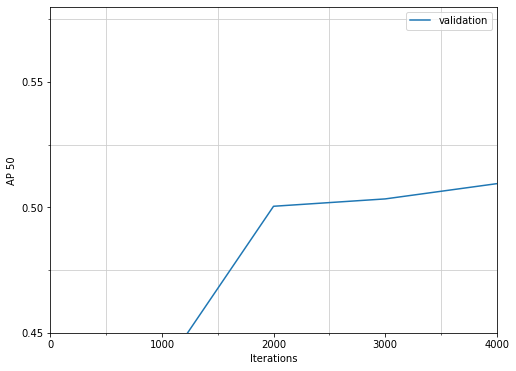

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.45, 0.58)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("AP 50")

mdf3 = mdf[~mdf["bbox/AP50"].isna()]
plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/AP50.png")

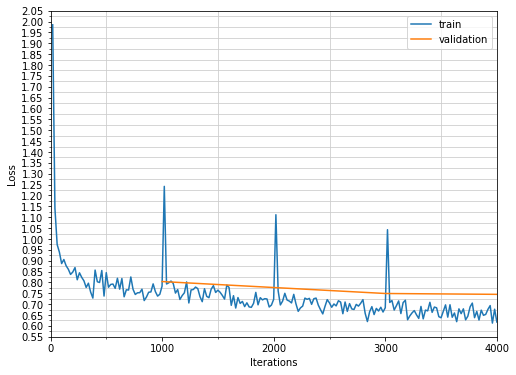

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.55, 2.05)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')

mdf1 = mdf[~mdf["total_loss"].isna()]
plt.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    plt.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/loss.png")